# Exploring the Decay Position Network

This is repeating a little bit of the work that Rachel did - but going straight to a training. This notebook will use keras.

## Config

In [1]:
func_adl_endpoint = 'http://localhost:31000'
datasets_for_training_datafile = "../data/datasets.csv"

# Constants derived in previous notebook. Need to be added to a python file of config constants.
lxyz_eta_division = 1.3
too_far_dist_lz = 7500
too_far_dist_lxy = 4400
too_short_dist_lxy=1300
too_short_dist_lz=3500

# How many events per training sample shall we train on?
training_events_per_sample = 4000
epochs_to_train = 100

# Columns to train on. This is partly gotten by looking at the `Input Variables` worksheet to remove blanks.
what_to_train_on = ['EMM_BL0', 'EMM_BL1', 'EMM_BL2',
       'EMM_BL3', 'EMM_EL0', 'EMM_EL1', 'EMM_EL2', 'EMM_EL3', 'EH_EL0',
       'EH_EL1', 'EH_EL2', 'EH_CBL0', 'EH_CBL1', 'EH_CVL2',
       'EH_TGL0', 'EH_TGL1', 'EH_TGL2', 'EH_EBL0', 'EH_EBL1', 'EH_EBL2', 'JetPt', 'JetEta']
# With an eta cut of 1.3, then EH_EL3 is also all zeros.
#  'FC_L0', 'FC_L1', 'FC_L2' - these seem to be all zeros as seen before.

## Python setup

In [2]:
# Designed not to be modified
import sys
sys.path.append("../")
from func_adl import EventDataset
from func_adl.xAOD import FuncADLServerException

from calratio_perjet_training.fetch_training_data import fetch_perjet_data
import glob
import numpy as np
import asyncio

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib import rcParams
plt.rc('font', size=14)
import seaborn as sns

import pandas as pd
#pd.set_option('display.max_rows', 500)
#pd.set_option('display.max_columns', 500)
#pd.set_option('display.width', 1000)

from keras.models import Sequential
from keras.layers import Dense, Dropout
import sklearn.metrics

Using TensorFlow backend.


## Load datasets

In [3]:
datasets = pd.read_csv(datasets_for_training_datafile).query('Use==1')
print(len(datasets))

57


In [4]:
async def fetch_data_async(info):
    try:
        d = await fetch_perjet_data(EventDataset(f'cacheds://{info.RucioDSName}'), f'{info.mH}_{info.mS}_{info.Lifetime}_{info.MCCampaign}', endpoint=func_adl_endpoint, jet_pt_cut=50.0, deltar_llp=0.2)
        return [info, f'{info.mH}_{info.mS}_{info.Lifetime}_{info.MCCampaign}', d]
    except FuncADLServerException as e:
        print (str(e))
        return None
all_datasets_future = [fetch_data_async(info) for index, info in datasets.iterrows()]
datasets_for_training = [f for f in (await asyncio.gather(*all_datasets_future)) if f is not None]

The request failed:
  Message: while building and running xAOD
  Log lines:
    Configured GCC from: /opt/lcg/gcc/6.2.0binutils/x86_64-slc6
    Configured AnalysisBase from: /usr/AnalysisBase/21.2.62/InstallArea/x86_64-slc6-gcc62-opt
    -- The C compiler identification is GNU 6.2.0
    -- The CXX compiler identification is GNU 6.2.0
    -- Check for working C compiler: /opt/lcg/gcc/6.2.0binutils/x86_64-slc6/bin/gcc
    -- Check for working C compiler: /opt/lcg/gcc/6.2.0binutils/x86_64-slc6/bin/gcc -- works
    -- Detecting C compiler ABI info
    -- Detecting C compiler ABI info - done
    -- Detecting C compile features
    -- Detecting C compile features - done
    -- Check for working CXX compiler: /opt/lcg/gcc/6.2.0binutils/x86_64-slc6/bin/g++
    -- Check for working CXX compiler: /opt/lcg/gcc/6.2.0binutils/x86_64-slc6/bin/g++ -- works
    -- Detecting CXX compiler ABI info
    -- Detecting CXX compiler ABI info - done
    -- Detecting CXX compile features
    -- Detecting CXX co

We need to split into training and testing sample sizes. Unfortunately, we have to do some calculations to understand if something is good signal to train on, or not. So we add a few columns here to all the datasets.

In [5]:
def add_useful_columns(ds):
    ds['Lxy'] = np.sqrt(ds.Lx*ds.Lx + ds.Ly*ds.Ly)

    ds['IsOutlier'] = False
    ds['IsOutlier'] |= ds.Lxy[ds.IsLLP & (np.abs(ds.JetEta) < lxyz_eta_division)] > too_far_dist_lxy
    ds['IsOutlier'] |= ds.Lz[ds.IsLLP & (np.abs(ds.JetEta) >= lxyz_eta_division)] > too_far_dist_lz

    ds['IsInlier'] = False
    ds['IsInlier'] |= ds.Lxy[ds.IsLLP & (np.abs(ds.JetEta) < lxyz_eta_division)] < too_short_dist_lxy
    ds['IsInlier'] |= ds.Lz[ds.IsLLP & (np.abs(ds.JetEta) >= lxyz_eta_division)] < too_short_dist_lz

    ds['JetIsCentral'] = np.abs(ds.JetEta) < lxyz_eta_division

    ds["Signal"] = ds.IsLLP & (ds.JetPt > 40) & (np.abs(ds.JetEta) < 2.4) & (ds.IsOutlier == False) & (ds.IsInlier == False) & (ds.JetIsCentral == True)

# We can limit how many datasets we combine to make life a little easier for testing with this line
what_to_combine = datasets_for_training #[20:35]
for d in what_to_combine:
    add_useful_columns(d[2])

In [7]:
all_training_jets = pd.DataFrame(pd.concat([d[2][d[2].Signal][:training_events_per_sample] for d in what_to_combine], keys=[(d[0].mH, d[0].mS, d[0].Lifetime, f'{d[0].mH}/{d[0].mS}', d[0].MCCampaign) for d in what_to_combine], names=['mH', 'mS', 'Lifetime', 'mH_mS', 'MC']).to_records())
all_testing_jets = pd.DataFrame(pd.concat([d[2][d[2].Signal][training_events_per_sample+1:] for d in what_to_combine], keys=[(d[0].mH, d[0].mS, d[0].Lifetime, f'{d[0].mH}/{d[0].mS}', d[0].MCCampaign) for d in what_to_combine], names=['mH', 'mS', 'Lifetime', 'mH_mS', 'MC']).to_records())

In [8]:
print (f'Number of training jets: {len(all_training_jets)}')
print (f'Number of testing jets: {len(all_testing_jets)}')

Number of training jets: 180000
Number of testing jets: 1431458


And quick reference for the columns we have in the data

In [9]:
all_training_jets.columns

Index(['mH', 'mS', 'Lifetime', 'mH_mS', 'MC', 'entry', 'RunNumber',
       'EventNumber', 'JetPt', 'JetEta', 'JetPhi', 'IsLLP', 'nLLPs_Near_Jets',
       'Lx', 'Ly', 'Lz', 'Leta', 'Lphi', 'Lpt', 'Lpz', 'EMM_BL0', 'EMM_BL1',
       'EMM_BL2', 'EMM_BL3', 'EMM_EL0', 'EMM_EL1', 'EMM_EL2', 'EMM_EL3',
       'EH_EL0', 'EH_EL1', 'EH_EL2', 'EH_EL3', 'EH_CBL0', 'EH_CBL1', 'EH_CVL2',
       'EH_TGL0', 'EH_TGL1', 'EH_TGL2', 'EH_EBL0', 'EH_EBL1', 'EH_EBL2',
       'FC_L0', 'FC_L1', 'FC_L2', 'Lxy', 'IsOutlier', 'IsInlier',
       'JetIsCentral', 'Signal'],
      dtype='object')

## Normalization

For this training best to center thinngs around the average before doing the training (or inference). Create some tools to do that.

In [10]:
def calc_normalization (p):
    return (p.mean(), p.std())

(input_mean, input_std) = calc_normalization(all_training_jets.filter(items=what_to_train_on))
(output_mean, output_std) = calc_normalization(all_training_jets.filter(items=['Lxy']))

def norm_inputs(p):
    return (p - input_mean) / input_std

def norm_outputs(p):
    return (p - output_mean[0]) / output_std[0]

def unnorm_outputs(p):
    return (p * output_std[0]) + output_mean[0]

In [11]:
y_train = norm_outputs(all_training_jets.Lxy)
x_train = norm_inputs(all_training_jets.filter(items=what_to_train_on))

In [12]:
x_train

,EMM_BL0,EMM_BL1,EMM_BL2,EMM_BL3,EMM_EL0,EMM_EL1,EMM_EL2,EMM_EL3,EH_EL0,EH_EL1,...,EH_CBL1,EH_CVL2,EH_TGL0,EH_TGL1,EH_TGL2,EH_EBL0,EH_EBL1,EH_EBL2,JetPt,JetEta
0,-0.371088,-0.653009,-0.741289,-0.481449,-0.083338,-0.130936,-0.126896,-0.067843,-0.042659,-0.02256,...,-0.863548,-0.384526,-0.217143,-0.162466,-0.364487,-0.234376,3.746240,0.929291,0.357325,-1.638339
1,-0.501237,0.162804,-0.193888,-0.471162,-0.083338,-0.130936,-0.126896,-0.067843,-0.042659,-0.02256,...,-0.860110,-0.384713,-0.068685,-0.152416,3.359192,-0.107573,2.138562,0.150986,-0.834155,1.386150
2,0.160631,-0.059862,-0.511437,-0.478529,-0.582081,0.371047,-0.516127,-0.067843,-0.042659,-0.02256,...,-0.862411,-0.384963,-0.081456,-0.146181,2.263136,1.776105,1.930148,0.083080,-0.410868,-1.590652
3,0.195460,0.079677,2.055902,1.370711,1.782881,2.261507,0.480297,0.185561,-0.042659,-0.02256,...,-0.863006,-0.384713,-0.217579,-0.154407,-0.269154,1.044447,-0.224524,-0.374879,-0.887178,-1.667641
4,1.567163,-0.120357,-0.479240,-0.422802,-0.083338,-0.130936,-0.126896,-0.067843,-0.042659,-0.02256,...,1.928319,-0.302555,-0.217579,-0.151088,-0.364443,-0.257301,-0.380990,-0.379473,-0.886096,-0.732391
5,-0.240139,1.472132,1.650539,-0.227147,-0.083338,-0.130936,-0.126896,-0.067843,-0.042659,-0.02256,...,-0.418886,-0.378634,-0.217579,-0.154407,-0.364443,-0.257301,-0.380990,-0.379473,-0.807154,0.124498
6,-0.064997,-0.346427,-0.489740,-0.392625,-0.083338,-0.130936,-0.126896,-0.067843,-0.042659,-0.02256,...,-0.866765,-0.384713,-0.298903,-0.145528,-0.323955,1.268200,3.829992,-0.226017,-0.491218,-1.662402
7,1.318785,-0.349100,-0.725124,-0.452321,-0.083338,-0.130936,-0.126896,-0.067843,-0.042659,-0.02256,...,-0.856196,-0.384377,5.766223,0.346016,-0.373133,-0.257301,-0.405016,2.817713,-0.825429,1.359075
8,0.340266,0.241978,-0.453902,-0.476403,-0.083338,-0.130936,-0.126896,-0.067843,-0.042659,-0.02256,...,1.810700,-0.333112,-0.217579,-0.154407,-0.364443,-0.257301,-0.380990,-0.379473,-0.923199,-0.039156
9,0.389115,0.628236,0.171709,-0.443536,-0.083338,-0.130936,-0.126896,-0.067843,-0.042659,-0.02256,...,0.951791,0.034751,-0.217579,-0.154407,-0.364443,-0.257301,-0.380990,-0.379473,-0.861957,-0.093045


## Build the Model

In [13]:
%%capture --no-stdout --no-display

model = Sequential()
model.add(Dense(64, activation='relu', input_dim=len(x_train.columns)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
# THis is the number of outputs - so could be 2 if we wanted to train both lxy and lz
# Activation might be softmax if we had more than one thing as we would would want it to some to some number.
# But since this is regression, we do not.
model.add(Dense(1))

#categorical_crossentropy
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train, y_train, batch_size=32, epochs=epochs_to_train, validation_split=0.25, shuffle=True);

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Train on 135000 samples, validate on 45000 samples
Epoch 1/100
135000/135000 [==============================] - 32s 235us/step - loss: 0.1124 - val_loss: 0.0991
Epoch 2/100
135000/135000 [==============================] - 55s 411us/step - loss: 0.0761 - val_loss: 0.0783
Epoch 3/100
135000/135000 [==============================] - 44s 327us/step - loss: 0.0700 - val_loss: 0.0825
Epoch 4/100
135000/135000 [==============================] - 12s 91us/step - loss: 0.0674 - val_loss: 0.0703
Epoch 5/100
135000/135000 [==============================] - 18s 131us/step - loss: 0.0658 - val_loss: 0.0761
Epoch 6/100
135000/135000 [==============================] - 15s 110us/step - loss: 0.0643 - val_loss: 0.0713
Epoch 7/100
135000/135000 [==============================] - 17s 126us/step - loss: 0.0636 - val_loss: 0.0746
Epoch 8/100
135000/135000 [==============================] - 17s 126us/step - loss: 0.0631 - val_loss: 0.0672
Epoch 9/100
135000/135000 [==============================] - 12s 87us/

## Predict

This is a little tricky in the sense we want to run the prediction for the whole table. We split out the testing stuff above. So normalize it and we are ready to go!
Note we have to un-normalize things before we get to plotting and comparing!

In [14]:
x_test = norm_inputs(all_testing_jets.filter(items=what_to_train_on))

In [15]:
y_predict = model.predict(x_test)

In [16]:
all_testing_jets['p_Lxy'] = np.array(unnorm_outputs(y_predict[:,0]))

## Comparisons

Lets look at how well the prediction does vs various things

In [17]:
all_testing_jets

,mH,mS,Lifetime,mH_mS,MC,entry,RunNumber,EventNumber,JetPt,JetEta,...,EH_EBL2,FC_L0,FC_L1,FC_L2,Lxy,IsOutlier,IsInlier,JetIsCentral,Signal,p_Lxy
0,60,5,5,60/5,mc16d,20339,300000.0,2188776.0,52.127543,0.432935,...,0.000000e+00,0.0,0.0,0.0,1951.929406,False,False,True,True,2156.003418
1,60,5,5,60/5,mc16d,20341,300000.0,2188148.0,108.261805,1.254804,...,8.271945e-01,0.0,0.0,0.0,3342.714070,False,False,True,True,3468.623535
2,60,5,5,60/5,mc16d,20351,300000.0,2188115.0,51.310191,-0.959329,...,2.214050e-03,0.0,0.0,0.0,1565.272297,False,False,True,True,1523.388184
3,60,5,5,60/5,mc16d,20354,300000.0,2189653.0,55.630766,-0.546247,...,0.000000e+00,0.0,0.0,0.0,1577.761358,False,False,True,True,1716.256836
4,60,5,5,60/5,mc16d,20357,300000.0,2188553.0,56.212719,1.005694,...,-5.659143e-03,0.0,0.0,0.0,2151.296023,False,False,True,True,2160.194824
5,60,5,5,60/5,mc16d,20361,300000.0,2188652.0,67.363453,-0.649984,...,9.174361e-05,0.0,0.0,0.0,2023.838946,False,False,True,True,2233.242432
6,60,5,5,60/5,mc16d,20372,300000.0,2189590.0,83.150633,-0.737707,...,0.000000e+00,0.0,0.0,0.0,1845.616999,False,False,True,True,1917.508545
7,60,5,5,60/5,mc16d,20374,300000.0,2189073.0,60.010227,0.790567,...,0.000000e+00,0.0,0.0,0.0,2329.044346,False,False,True,True,1830.749878
8,60,5,5,60/5,mc16d,20378,300000.0,2189288.0,63.696277,-0.508225,...,-4.636318e-04,0.0,0.0,0.0,1358.412554,False,False,True,True,1470.566772
9,60,5,5,60/5,mc16d,20380,300000.0,2188026.0,52.829832,-0.093863,...,0.000000e+00,0.0,0.0,0.0,2619.868786,False,False,True,True,2557.832520


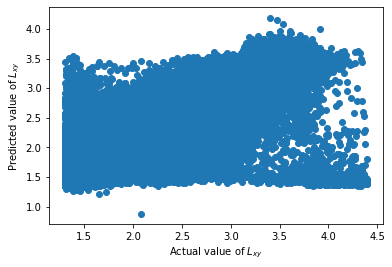

In [18]:
plt.scatter(x=all_testing_jets.Lxy/1000.0, y=all_testing_jets.p_Lxy/1000.0)
plt.xlabel('Actual value of $L_{xy}$')
plt.ylabel('Predicted value of $L_{xy}$')
plt.show()

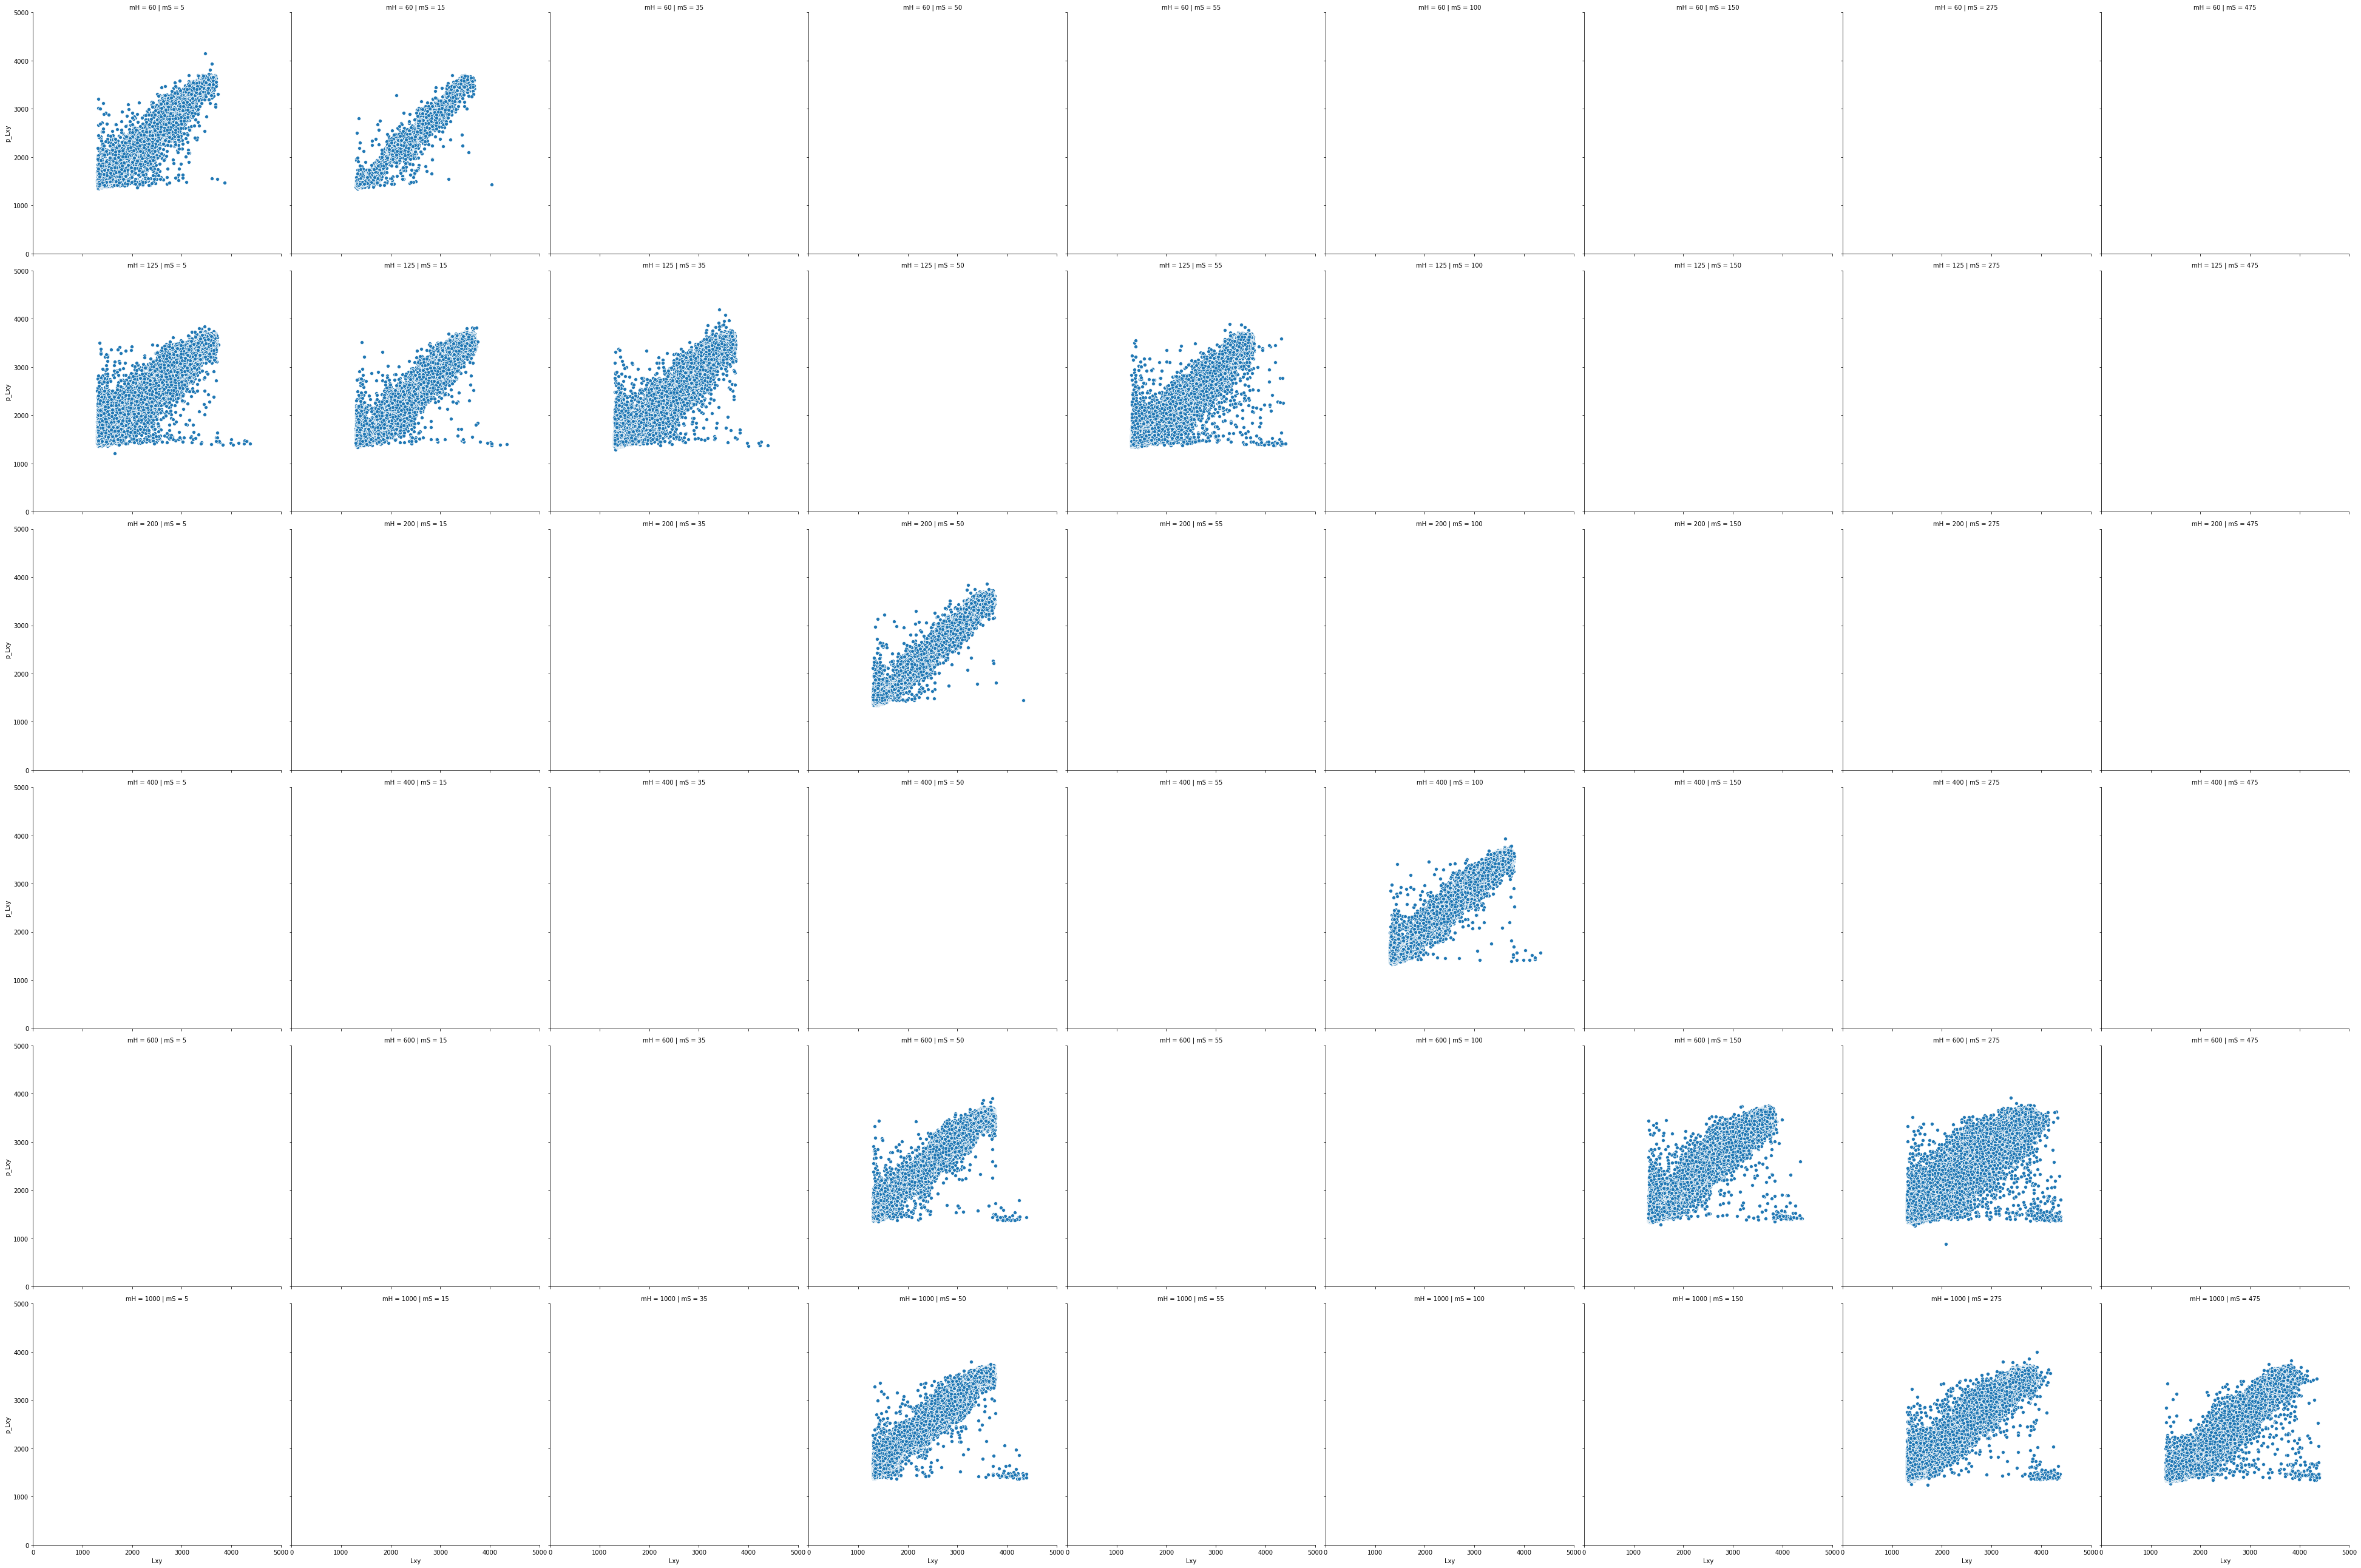

In [19]:
mass_comparison = sns.relplot(x='Lxy', y='p_Lxy', kind='scatter', data=all_testing_jets, row='mH', col='mS', height=6, aspect=1)
mass_comparison.set(ylim=(0.0, 5000.0))
mass_comparison.set(xlim=(0.0, 5000.0))

In [20]:
what_to_train_on

['EMM_BL0',
 'EMM_BL1',
 'EMM_BL2',
 'EMM_BL3',
 'EMM_EL0',
 'EMM_EL1',
 'EMM_EL2',
 'EMM_EL3',
 'EH_EL0',
 'EH_EL1',
 'EH_EL2',
 'EH_CBL0',
 'EH_CBL1',
 'EH_CVL2',
 'EH_TGL0',
 'EH_TGL1',
 'EH_TGL2',
 'EH_EBL0',
 'EH_EBL1',
 'EH_EBL2',
 'JetPt',
 'JetEta']

## The Calorimeter Edge Effect

Looking at these plots there are many of them that have a seeming edge - a group of jets that have $L_{xy}$ that run along the calorimeter, but are all predicted to be at the face. My guess is this is connected with pileup somehow. So this is just an irreducable background.

First, lets isolate them.

In [21]:
all_testing_jets['EdgeBadReco'] = (all_testing_jets.p_Lxy < 1750) & (all_testing_jets.Lxy > 2500)

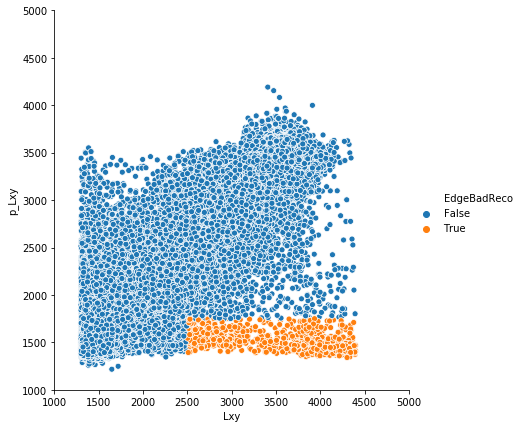

In [38]:
mass_comparison = sns.relplot(x='Lxy', y='p_Lxy', kind='scatter', hue='EdgeBadReco', data=all_testing_jets, height=6, aspect=1)
mass_comparison.set(ylim=(1000.0, 5000.0))
mass_comparison.set(xlim=(1000.0, 5000.0))

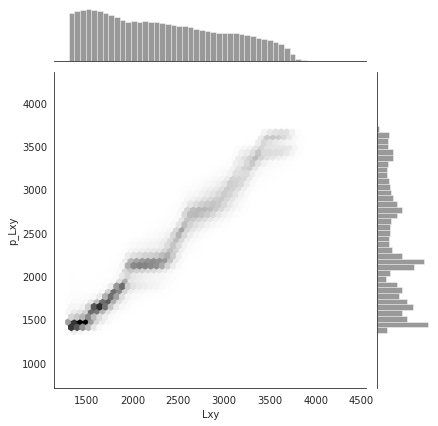

In [23]:
with sns.axes_style("white"):
    sns.jointplot(x='Lxy', y='p_Lxy', kind="hex", color="k", height=6, data=all_testing_jets)

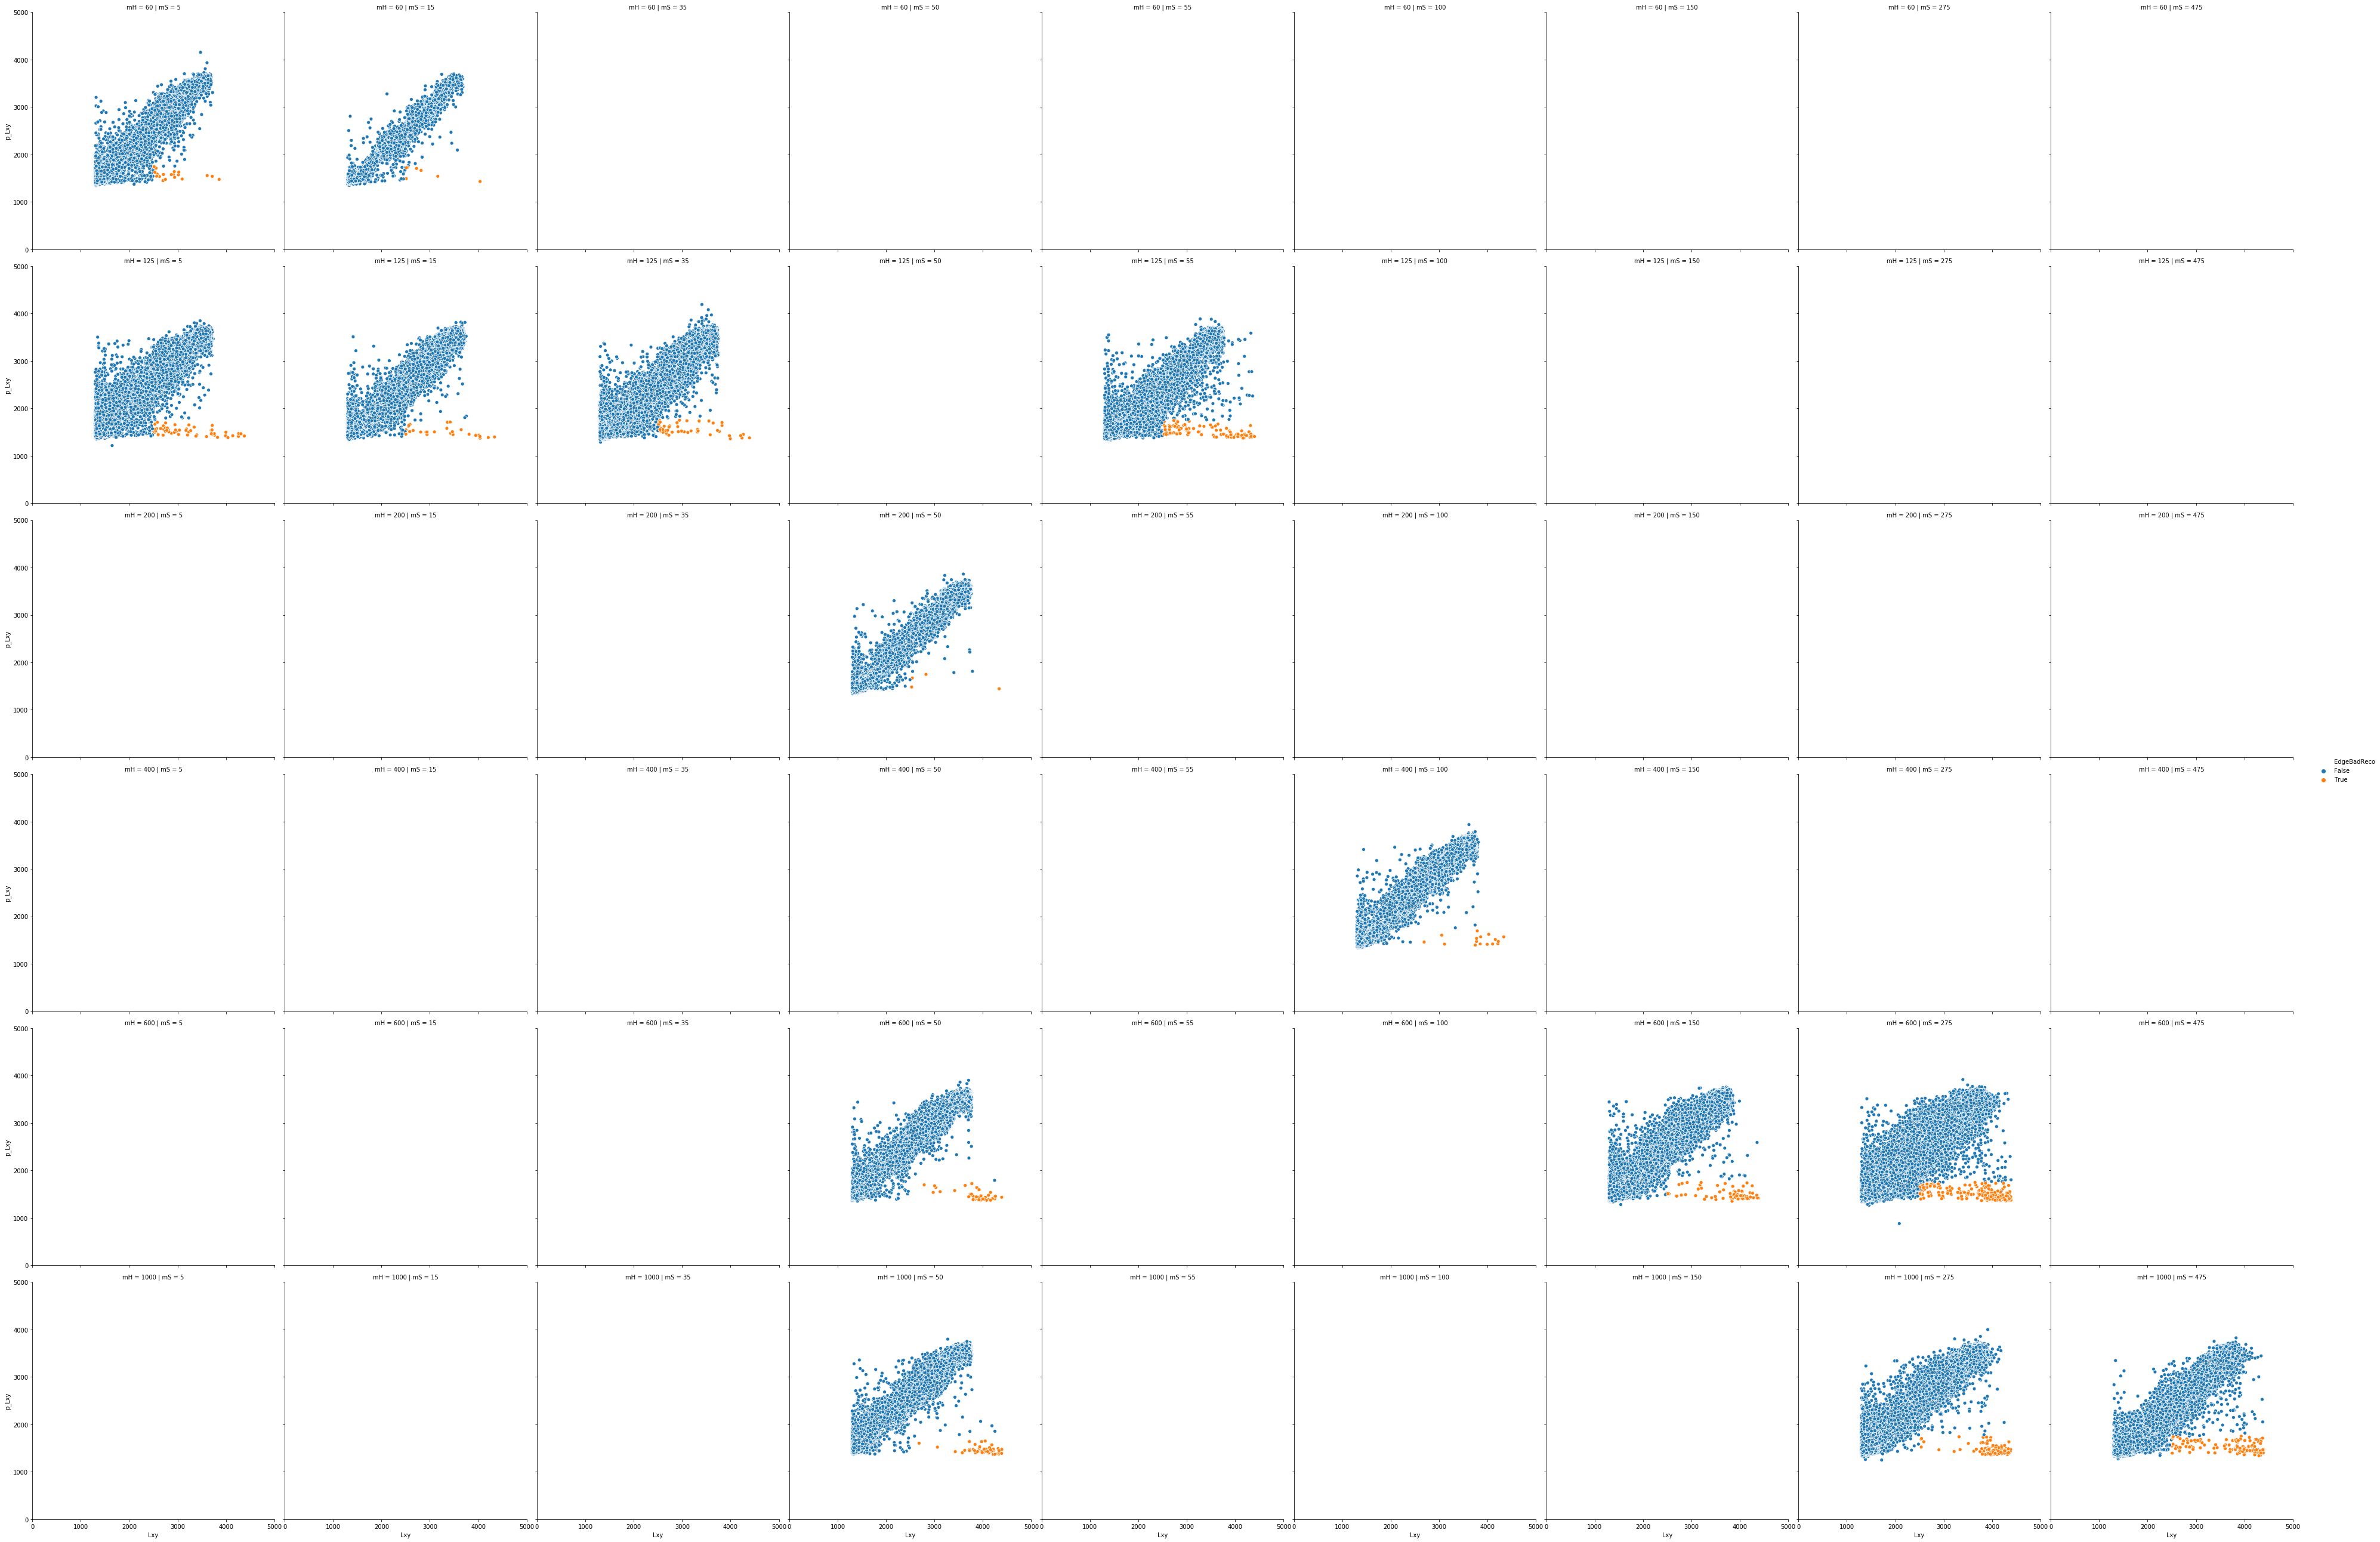

In [24]:
mass_comparison = sns.relplot(x='Lxy', y='p_Lxy', kind='scatter', hue='EdgeBadReco', data=all_testing_jets, row='mH', col='mS', height=6, aspect=1)
mass_comparison.set(ylim=(0.0, 5000.0))
mass_comparison.set(xlim=(0.0, 5000.0))

### Kinematics?

Get an idea behind simple kinematics.

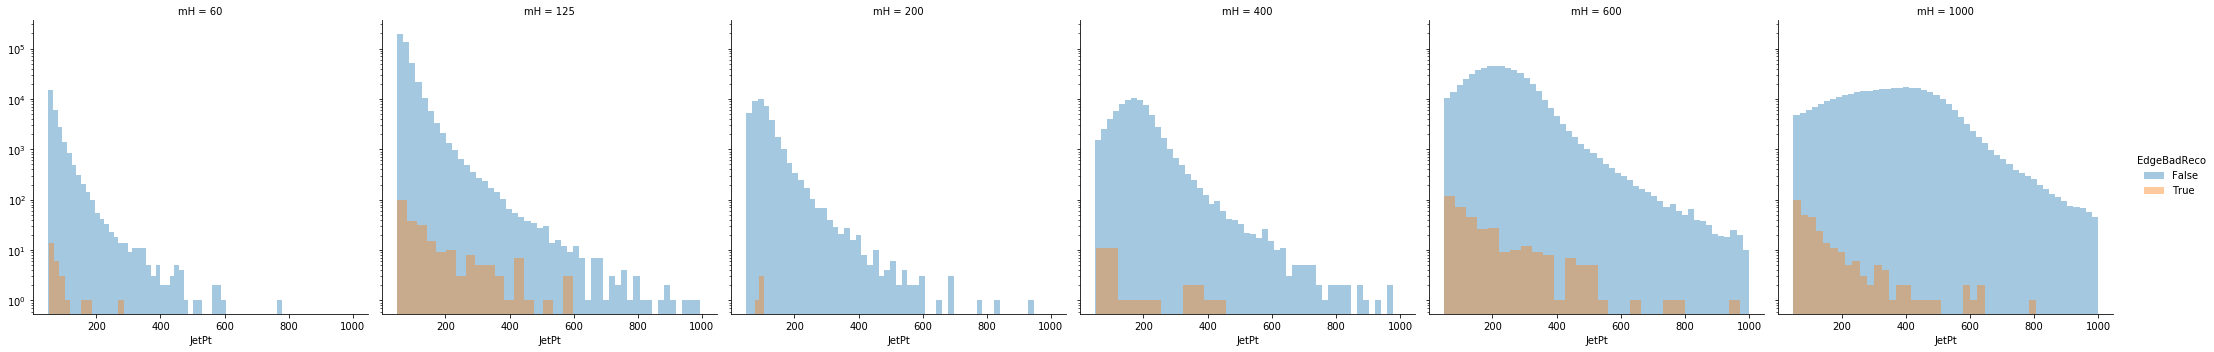

In [25]:
#sns.distplot(x='JetPt', hue='EdgeBadReco', data=all_testing_jets)
g = sns.FacetGrid(all_testing_jets[all_testing_jets.JetPt < 1000], col="mH", hue='EdgeBadReco', height=5)
g.map(sns.distplot, 'JetPt', norm_hist=False, kde=False)
g.set(yscale='log')
g.add_legend()

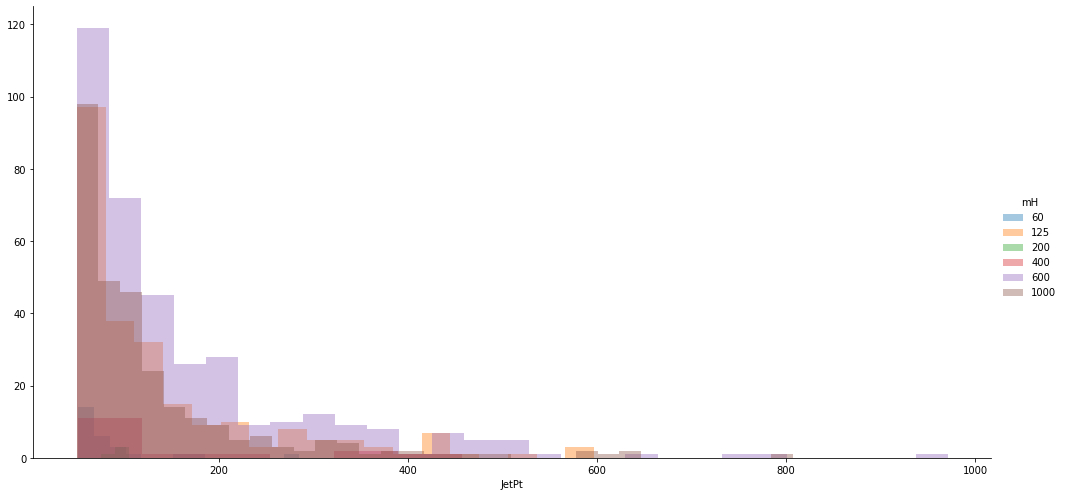

In [26]:
g = sns.FacetGrid(all_testing_jets[(all_testing_jets.JetPt < 1000) & (all_testing_jets.EdgeBadReco==True)], hue='mH', height=7, aspect=2)
g.map(sns.distplot, 'JetPt', norm_hist=False, kde=False)
g.add_legend()

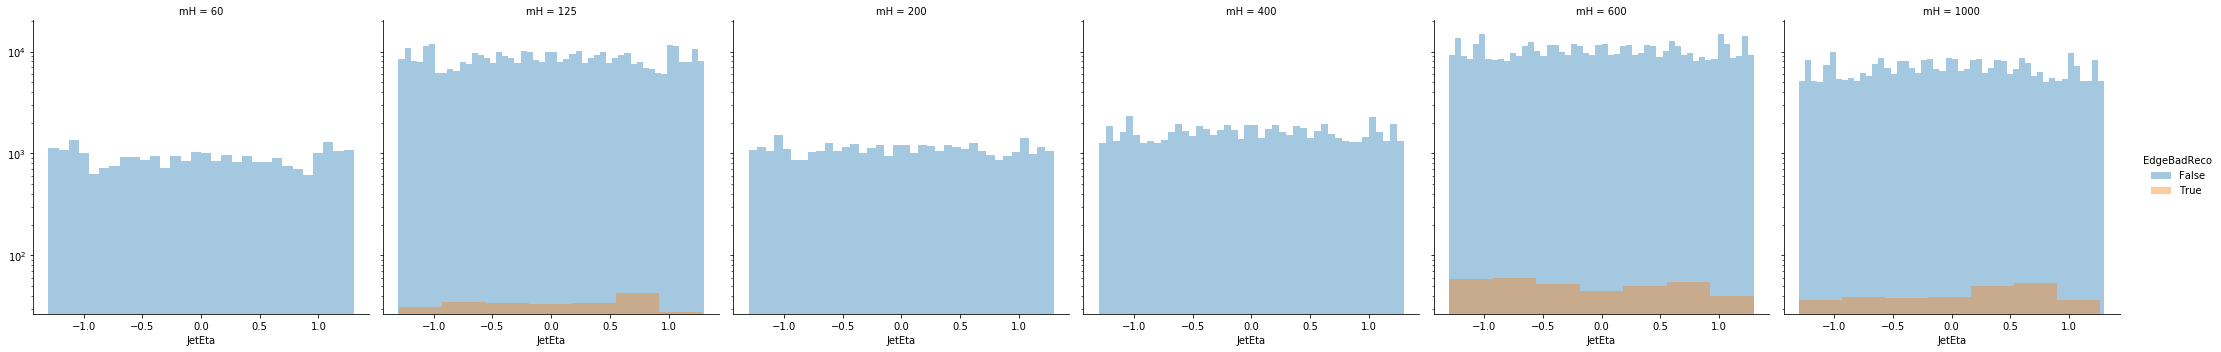

In [27]:
#sns.distplot(x='JetPt', hue='EdgeBadReco', data=all_testing_jets)
g = sns.FacetGrid(all_testing_jets[all_testing_jets.JetPt < 1000], col="mH", hue='EdgeBadReco', height=5)
g.map(sns.distplot, 'JetEta', norm_hist=False, kde=False)
g.set(yscale='log')
g.add_legend()

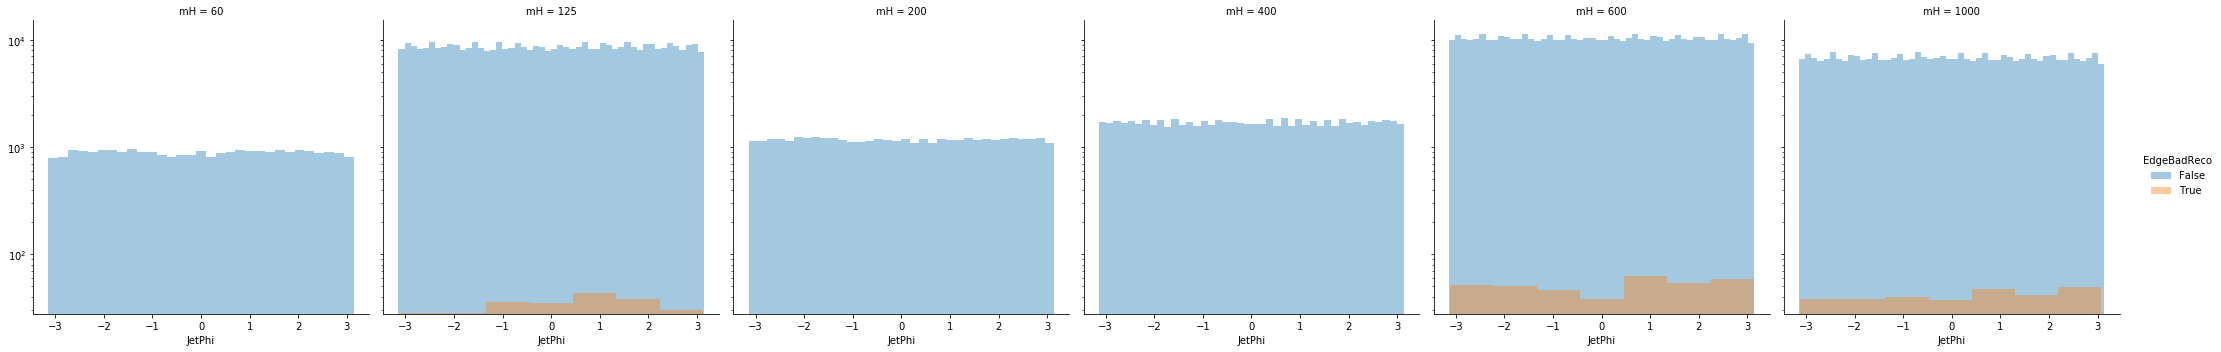

In [28]:
#sns.distplot(x='JetPt', hue='EdgeBadReco', data=all_testing_jets)
g = sns.FacetGrid(all_testing_jets[all_testing_jets.JetPt < 1000], col="mH", hue='EdgeBadReco', height=5)
g.map(sns.distplot, 'JetPhi', norm_hist=False, kde=False)
g.set(yscale='log')
g.add_legend()

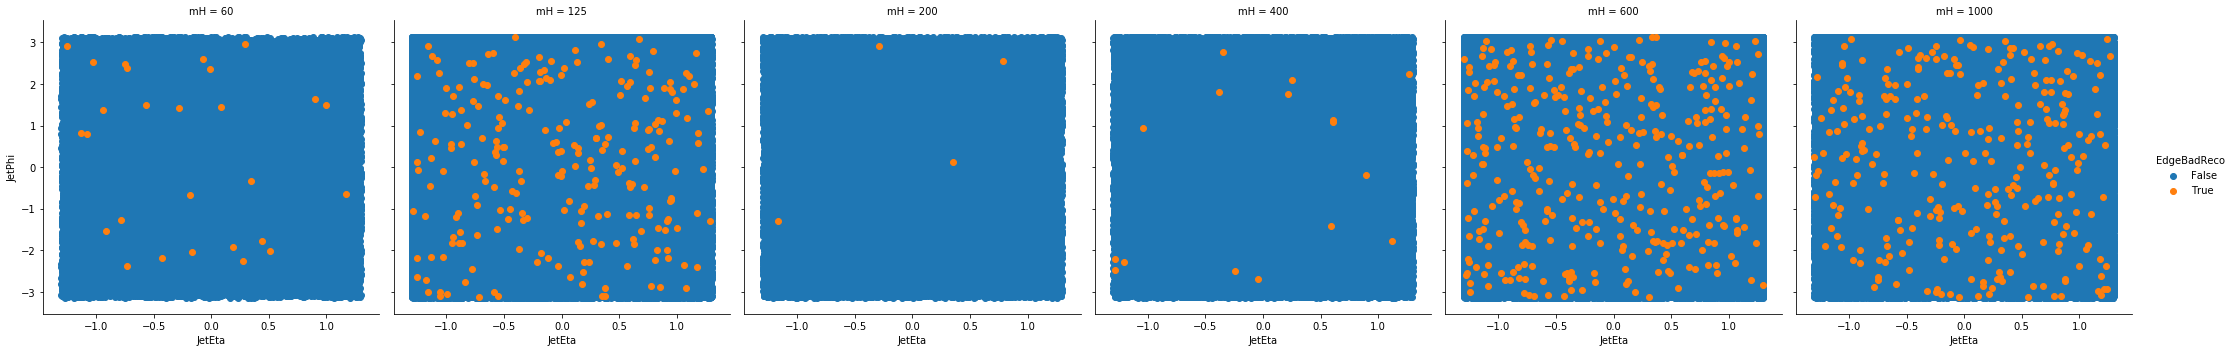

In [29]:
#sns.distplot(x='JetPt', hue='EdgeBadReco', data=all_testing_jets)
g = sns.FacetGrid(all_testing_jets[all_testing_jets.JetPt < 1000], col="mH", hue='EdgeBadReco', height=5)
g.map(plt.scatter, 'JetEta', 'JetPhi')
g.add_legend()

Lets look at the inner layer of the EM. We know from the input variables plot that it is not really responding for an $L_{xy} > 1750$ mm. So that means that we should see little energy there. If there is another jet - like a pileup jet, then we should see an energy deposit there.

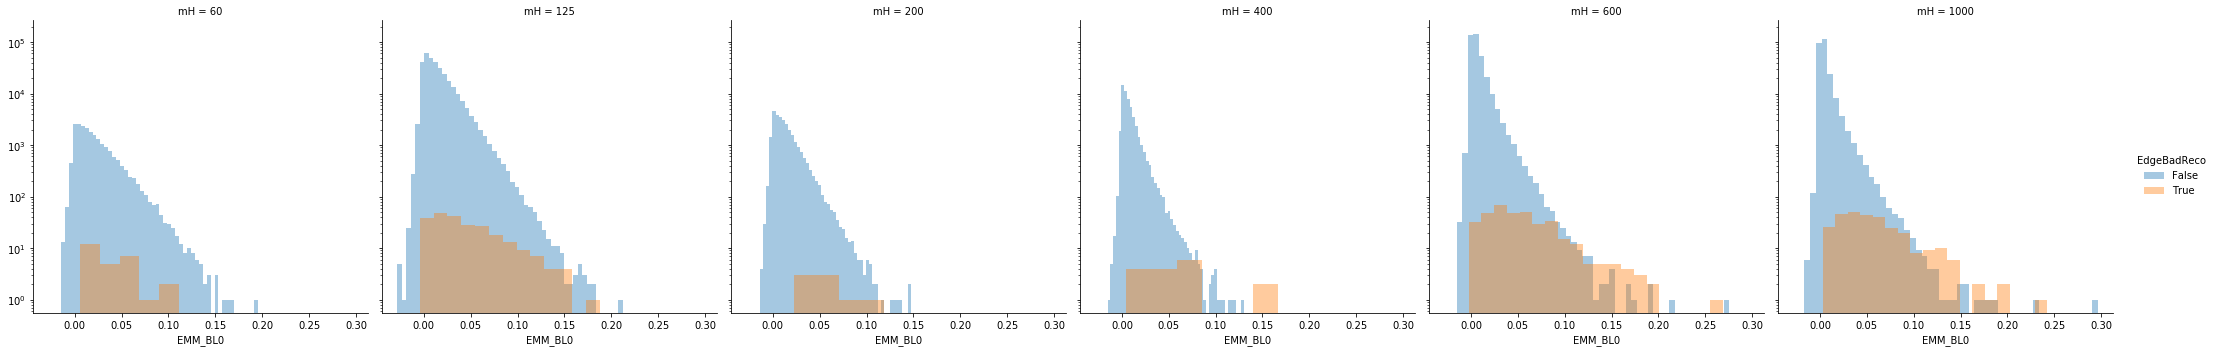

In [30]:
#sns.distplot(x='JetPt', hue='EdgeBadReco', data=all_testing_jets)
g = sns.FacetGrid(all_testing_jets[(all_testing_jets.JetPt < 1000) & (all_testing_jets.Lxy > 1750)], col="mH", hue='EdgeBadReco', height=5)
g.map(sns.distplot, 'EMM_BL0', norm_hist=False, kde=False)
g.set(yscale='log')
g.add_legend()

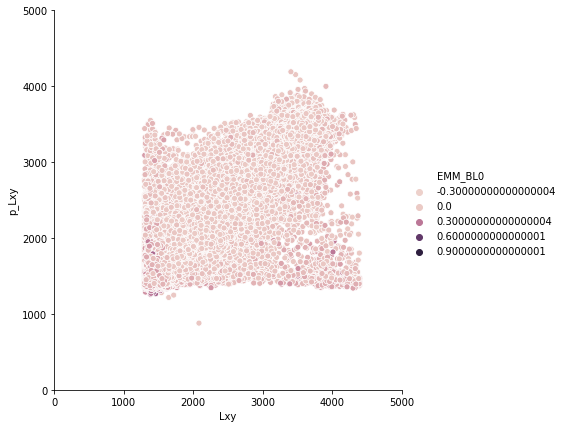

In [31]:
mass_comparison = sns.relplot(x='Lxy', y='p_Lxy', kind='scatter', hue='EMM_BL0', data=all_testing_jets, height=6, aspect=1)
mass_comparison.set(ylim=(0.0, 5000.0))
mass_comparison.set(xlim=(0.0, 5000.0))

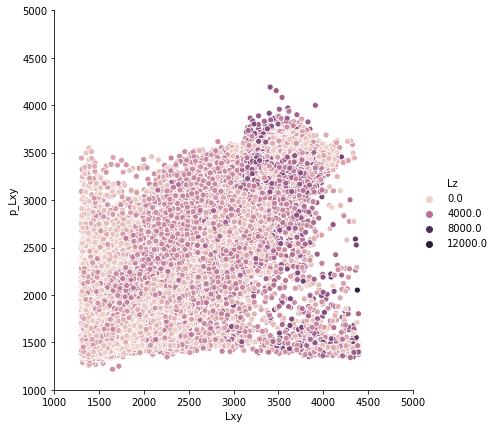

In [32]:
mass_comparison = sns.relplot(x='Lxy', y='p_Lxy', kind='scatter', hue='Lz', data=all_testing_jets, height=6, aspect=1)
mass_comparison.set(ylim=(1000.0, 5000.0))
mass_comparison.set(xlim=(1000.0, 5000.0))

Some of these look like they have very very high $L_z$ values and also high $L_xy$ - which doesn't make sense from the POV of $|\eta|<1.3$ cut. Lets quickly look at a few of these.

In [33]:
all_testing_jets[(all_testing_jets.EdgeBadReco==True) & (all_testing_jets.Lz > 9000.0)].filter(items=['JetEta', 'Lxy', 'Lz'])

,JetEta,Lxy,Lz


Hmmm... first of all - repeated events. That isn't good! Second, the error was looking at $p_L_{xy}$, not $L_{xy}$. Ok that makes lots more sense.

I admit to being a bit suprised. This 2D plot is inconclusive:

- On one hand, it the well reconstructed often has lower energy than this guy.
- But that isn't always the case!

We can definately conclude that EMM_BL0 is higher for these funny jets. But it isn't black & white.

Lets look at the difference in $p_T$ between the LLP and the jet.

In [34]:
all_testing_jets['DeltaMCPt'] = np.abs(all_testing_jets.JetPt - all_testing_jets.Lpt)/all_testing_jets.Lpt

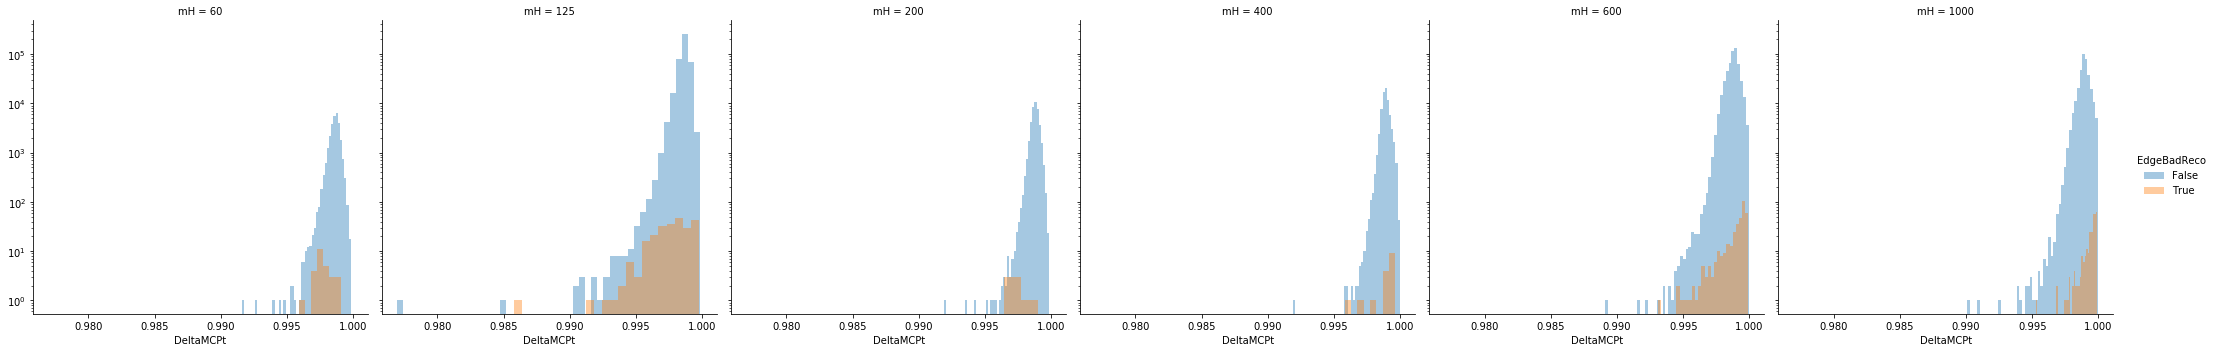

In [35]:
g = sns.FacetGrid(all_testing_jets[all_testing_jets.JetPt < 1000], col="mH", hue='EdgeBadReco', height=5)
g.map(sns.distplot, 'DeltaMCPt', norm_hist=False, kde=False)
g.set(yscale='log')
g.add_legend()

In [36]:
all_testing_jets['DeltaMCPtRaw'] = (all_testing_jets.JetPt - all_testing_jets.Lpt)/all_testing_jets.Lpt

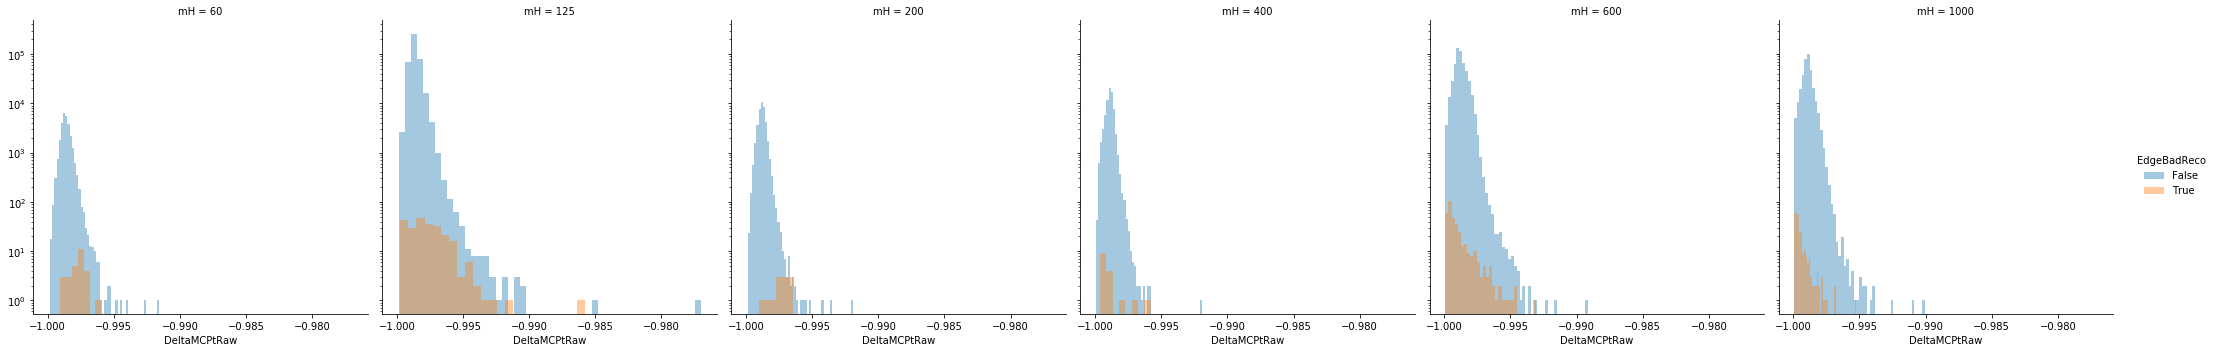

In [37]:
g = sns.FacetGrid(all_testing_jets[all_testing_jets.JetPt < 1000], col="mH", hue='EdgeBadReco', height=5)
g.map(sns.distplot, 'DeltaMCPtRaw', norm_hist=False, kde=False)
g.set(yscale='log')
g.add_legend()